# Computer Assignment 5
## Feature Detection, Image Stitching

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve as convolveim
import scipy.ndimage.filters as filters
from scipy.ndimage import gaussian_filter1d
import scipy.ndimage as ndimage

## PART A - Harris detector

- Write your own program for Harris corner point detection at a fixed scale. Your program should contain the following steps:
 - (a)  Generate gradient images of Ix and Iy using filters corresponding to derivative of Gaussian functions of a chosen **scale σ and window size w** (let us use w=4σ+1). You can use the convolve function from scipy.
 - (b) Compute three images **Ix^2 , Iy^2 , Ix* Iy**.
 - (c) To determine the Harris value at each pixel, we should apply Gaussian weighting over a window size of WxW centered at this pixel to each of the image Ix^2, Iy^2, and Ix Iy, and then sum the weighted average. This is equivalent to convolve each of these images by a Gaussian filter with size WxW. Let us use a Gaussian filter with scale 2σ, and window size W=6σ+1.
 - (d) Generate an image of Harris corner value based on the images from (c). See slide 15 and 16 from _feature detection_ lecture notes.
 - (e) Detect local maxima in the Harris value image (For each pixel, look at a 7x7 window centered at the pixel. Keep the pixel only if it is greater than all other pixels in this window). **Pick the first N feature points with largest Harris values.**
 - (f) Mark each detected point using a small circle. Display the image with the detected points.
 - You should write your own functions to generate Guassian and derivative of Gaussian filters from the analytical forms.
- Apply your Harris detector to a test image (you can just work on gray scale image). Using σ=1, N=100. Do the features detected make sense?


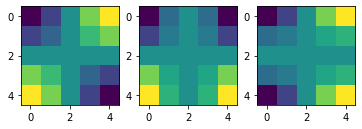

In [ ]:
def gauss(size, sigma):
  # This function will generate 3 filters: gaussian filter, two derivative of gaussian filters in x and y direction.
  ################################################ TODO ###############################################
  # define the x range
  x_ax = np.arange(0,size) - size/2 + 0.5
      
  gauss = filters.gaussian_filter1d(x_ax,sigma) # make 1D gaussian filter
  gauss2 = gauss[:,np.newaxis]*gauss # Compose 2D Gaussian filter from 1D
  f = np.min(gauss2)
  gauss1 =  gauss2/f # Normalize the filter so that all coefficients sum to 1
  
  # Create derivatives of gaussian 
  gauss1_dx = np.matrix(np.zeros((np.shape(gauss1)), dtype="float32"))
  gauss1_dy = np.matrix(np.zeros((np.shape(gauss1)), dtype="float32"))
  for j in range(0, len(x_ax)):
      gauss1_dx[:, j] = (gauss1[:, j] * (-x_ax[j])/(sigma*sigma)).reshape(size,1) # derivative filter in x
      ################################################ TODO ###############################################
      gauss1_dy[j, :] = (gauss1[j, :] * (-x_ax[j])/(sigma*sigma)).reshape(1,size)  # similarly define the difference in y
  return gauss1,gauss1_dx, gauss1_dy

################################################ TODO ###############################################
# Visualize the filters you created to make sure you are working with the correct filters
gauss1, gauss1_dx, gauss1_dy = gauss(5,1)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(gauss1)
plt.subplot(1,3,2)
plt.imshow(gauss1_dx)
plt.subplot(1,3,3)
plt.imshow(gauss1_dy)

In [ ]:
def harris(Ix, Iy , input_image,N):
  # The input to this function are the gradient images in x and y directions, the original image and N
  # The function will output two arrays/lists x and y which are the N points with largest harris values,
  # and an image of the harris values.
  l, m = np.shape(input_image)
  ################################################ TODO ###############################################
  #forming 3 images
  Ix2 = Ix*Ix #Ix square
  Iy2 = Iy*Iy #Iy square
  Ixy = Ix*Iy #Ix*Iy
  
  # smooth image Ix2, Iy2, Ixy  with Gaussian filter with sigma=2, size=7.
  gauss_smooth, _, _ = gauss(7,2)
  Ix2_smooth = convolveim(Ix2, gauss_smooth, mode='nearest')
  ################################################ TODO ###############################################
  Iy2_smooth = convolveim(Iy2, gauss_smooth, mode='nearest')  # CONVOLVE as shown above
  Ixy_smooth = convolveim(Ixy, gauss_smooth, mode='nearest')
  ## By doing this, Ix2_smooth, Iy2_smooth, Ixy_smooth are the three values needed to calculate the A matrix for each pixel.

  A = [[Ix2_smooth,Ixy_smooth],[Ixy_smooth,Iy2_smooth]]
  
  ################################################ TODO ###############################################
  # write code segment to find N harris points in the image
  det = Ix2_smooth*Iy2_smooth - Ixy_smooth*Ixy_smooth
  trace = Ix2_smooth + Iy2_smooth
  H = det - 0.06*(trace**2)
  ################################################ TODO ###############################################
  H0 = H    #save a copy of the original harris values before detecting local max
  ### Detect local maximum over 7x7 windows
  local_max_win = 7
  a = int(np.floor(local_max_win/2)) # a=3
  H = np.pad(H,((a,a),(a,a)), 'constant')
  H_max = np.ones(H.shape)      # Initialize a mask to be all ones
  for i in range(a,l+a):
      for j in range(a,m+a):
          # Take a WxW patch centered at point (i,j), check if the center point is larger than all other points
          # in this patch. If it is NOT local max, set H_max[i,j] = 0
          patch = H[i-4:i+3,j-4:j+3]
          for c in range(patch.shape[0]):
            for d in range(patch.shape[1]):
              if (H[i,j] < patch[c][d]):
                H_max[i,j]= 0
            

  H = H_max*H      # Multiply the mask with H, points that are not local max will become zero
  H = H[a:-a,a:-a]
  print(H.shape)
  print(type(H))
  #print(H.ravel())
  # Find largest N points' coordinates
  # Hint: use np.argsort() and np.unravel_index() to sort H and get the index in sorted order
  k = np.unravel_index(np.argsort(H.ravel()),H.shape)
  k1 = np.asarray(k)
  x = k1[0,-N:]
  y = k1[1,-N:] 
  # x,y should be arrays/lists of x and y coordinates of the harris points.
  return x,y,H0

No handles with labels found to put in legend.


(512, 768)
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'H0 Hariss Value Image')

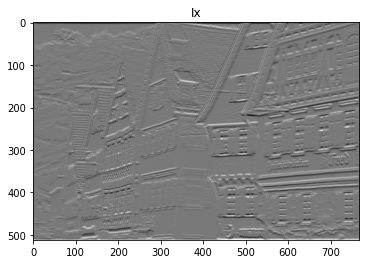

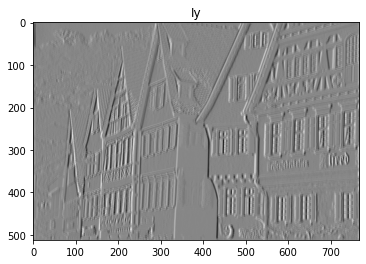

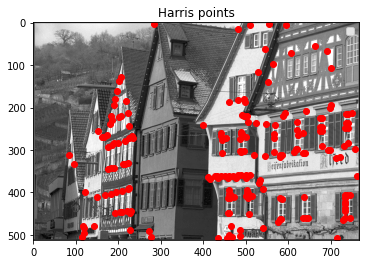

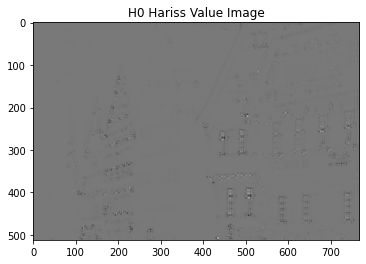

In [ ]:
################################################ TODO ###############################################
##### IMPORTANT: Convert your image to float once you load the image. ######
input_image = cv2.imread('8.png',0).astype('float')# input image

img = cv2.normalize(input_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

################################################ TODO ###############################################
# Generating the gaussian filter
sigma = 1
size = int(4*sigma + 1)
gauss_filt, gauss_filt_dx, gauss_filt_dy = gauss(size,sigma) # function call to gauss

    
################################################ TODO ###############################################
#Convolving the filter with the image
Ix = convolveim(img,gauss_filt_dx,mode ='nearest') # convolve image with dx filter
Iy = convolveim(img,gauss_filt_dy,mode ='nearest') # convolve image with dy filter

x,y,H0 = harris(Ix, Iy , img, 200)
################################################ TODO ###############################################
# Plot: Ix, Iy, Original image with harris point labeled in red dots, H0 harris value image
# Hint: you may use "plt.plot(y,x, 'ro')"   # Note: x is up/down and y is left/right in our above definition
                                            # But when plotting the point, the definition is reversed
plt.figure()
plt.imshow(Ix,'gray')
plt.title('Ix')

plt.figure()
plt.imshow(Iy,'gray')
plt.title('Iy')

plt.figure()
plt.imshow(img,'gray')
plt.plot(y,x, 'ro')
plt.title('Harris points')
plt.legend()

plt.figure()
plt.imshow(H0,'gray')
plt.title('H0 Hariss Value Image')

## PART B - SIFT descriptor

Write a program that can generate SIFT descriptor for each detected feature point using your program in Prob. 1. You may follow the following steps:
- Generate gradient images Ix and Iy as before. Furthermore, determine the gradient magnitude and orientation from Ix and Iy at every pixel.
-  Quantize the orientation of each pixel to one of the N=8 bins. Suppose your original orientation is x. To quantize the entire range of 360 degree to 8 bins, the bin size is q=360/N=45 degree. Assuming your orientation is determined with a range of [0,360]. x_q will range from 0 to 7, with 0 corresponding to degree (0, 22.5) and (360-22.5, 360). You can perform quantization using:  x_q=floor((x+q/2)/q); but if x_q=N, change to -> x_q=0
- Then for each detected feature point, follow these steps to generate the SIFT descriptor:
    - i) Generate a patch of size 16x16 centered at the detected feature point;
    - ii) Multiply the gradient magnitude with a Guassian window with scale= patch width/2. 
    - iii) Generate a HoG for the entire patch using the weighted gradient magnitude.
    - iv) Determine the dominant orientation of the patch by detecting the peak in the Hog determined in (iii).
    - v) Generate a HoG for each of the 4x4 cell in the 16x16 patch.
    - vi) Shift each HoG so that the dominant orientation becomes the first bin. 
    - vii) Concatenate the HoG for all 16 cells into a single vector.
    - viii) Normalize the vector. That is, divide each entry by L2 norm of the vector. 
    - ix) Clip the normalized vector so that entries >0.2 is set to 0.2.
    - x) Renormalize the vector resulting from (ix).

In [ ]:
def histo(theta4,mag4):
    # theta4 is an array of quantized orientations, with values 0,1,2...7.
    # mag4 is an array of the same size with magnitudes
    temp = np.zeros((1,8),dtype='float32')
    ################################################ TODO ###############################################
    # write code segment to add the magnitudes of all vectors in same orientations
    for i in range(theta4.shape[0]):
      for j in range(theta4.shape[1]):
        if(theta4[i][j] == 0):
          temp[0][0] += mag4[i][j]
        if(theta4[i][j] == 1):
          temp[0][1] += mag4[i][j]
        if(theta4[i][j] == 2):
          temp[0][2] += mag4[i][j]
        if(theta4[i][j] == 3):
          temp[0][3] += mag4[i][j]
        if(theta4[i][j] == 4):
          temp[0][4] += mag4[i][j]
        if(theta4[i][j] == 5):
          temp[0][5] += mag4[i][j]
        if(theta4[i][j] == 6):
          temp[0][6] += mag4[i][j]
        if(theta4[i][j] == 7):
          temp[0][7] += mag4[i][j]
    
    # temp should be a 1x8 vector, where each value corresponds to an orientation and 
    # contains the sum of all gradient magnitude, oriented in that orientation
    return temp

def descriptor(theta16,mag16):
    # Given a 16x16 patch of theta and magnitude, generate a (1x128) descriptor
    filt,_,_ = gauss(16,8) 
    mag16_filt = mag16*filt

    # array to store the descriptor. Note that in the end descriptor should have size (1, 128)
    desp = np.array([])
    temp1 = np.zeros((1,8))
    ################################################ TODO ###############################################
    histo16 = histo(theta16,mag16_filt) # make function call to histo, with arguments theta16 and mag16_fil
    #maxloc_theta16 = 

    for i in range(0,16,4):
      for j in range(0,16,4):
        ################################################ TODO ###############################################
        # use histo function to create histogram of oriantations on 4x4 patches in the neighbourhood of the harris points
        # you should shift your histogram for each cell so that the dominant orientation of the 16x16 patch becomes the first quantized orientation
        # you should update the variable desp to store all the orientation magnitude sum for each sub region of size 4x4
        h = histo(theta16[i:i+4,j:j+4] , mag16[i:i+4,j:j+4])
        temp1 = np.append(temp1, h, axis =1 )   

    desp = temp1[:,8:136]

    ################################################ TODO ###############################################
    # normalize descriptor, clip descriptor, normalize descriptor again
    desp = desp / np.linalg.norm(desp)
    for i in range(desp.shape[0]):
      for j in range(desp.shape[1]):
        if(desp[i][j] > 0.2):
          desp[i][j] = 0.2
    
    desp = desp / np.linalg.norm(desp)    
    desp = np.matrix(desp)

    return desp


In [ ]:
def part_B(input_image):

  # normalize the image
  img = cv2.normalize(input_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  # Generate derivative of Gaussian filters, using sigma=1, filter window size=4*sigma+1
  sigma = 1
  size = int(4*sigma+1)
  _, filt_dx, filt_dy = gauss(size, sigma)
  
  ################################################ TODO ###############################################
  img_x = convolveim(input_image,filt_dx,mode ='nearest')    # image convolved with filt_dx
  img_y = convolveim(input_image,filt_dy,mode ='nearest') 

  # Calculate magnitude and theta, then quantize theta.
  mag = np.sqrt(img_x ** 2 + img_y ** 2)
  mag = mag.astype(float)

  theta = np.arctan2(img_y, img_x)
  theta = theta.astype(float)
  
  theta = theta*180/np.pi

  for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
      if(theta[i][j]<0):
        theta[i][j] = 360 + theta[i][j]
  
  theta_q = np.zeros(theta.shape)
  ## Quantize theta to 0,1,2,... 7, see instructions above
  N = 8
  q = 360 / N
  for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
      theta_q[i][j] = np.floor((theta[i][j] + q/2) / q)
      if(theta_q[i][j] == 8):
        theta_q[i][j] = 0
    
  ################################################ TODO ###############################################
  x,y,_ = harris(img_x,img_y,input_image,100) # call harris function to find 100 feature points 
  
  # Pad 15 rows and columns. You will need this extra border to get a patch centered at the feature point 
  #    when the feature points lie on the original border of the image.
  theta_q = cv2.copyMakeBorder(theta_q.astype('uint8'), 7,8,7,8, cv2.BORDER_REFLECT)
  ################################################ TODO ###############################################
  mag =  cv2.copyMakeBorder(mag.astype('uint8'), 7,8,7,8, cv2.BORDER_REFLECT) # similarly add border to the magnitude image
  final_descriptor = np.zeros((1,128))
  final_points = np.zeros((1,100))

  for i in range(0,final_points.shape[1]):
    # Since you have already added 15 rows and columns, now the new coordinates of the feature points are (x+8, y+8).
    # Then the patch should be [x[i]:x[i]+16,y[i]:y[i]16]
    theta_temp = theta_q[x[i]:x[i]+16,y[i]:y[i]+16] # Your patch should be centered at the feature point.
    #print('theta_temp',final_descriptor.shape)
    mag_temp = mag[x[i]:x[i]+16,y[i]:y[i]+16] # similarly, take a 16x16 patch of mag around the point
    #print('mag_temp',final_descriptor.shape)
    temp2 = descriptor(theta_temp,mag_temp) # function call to descriptors
    #print('temp2',final_descriptor.shape)
    final_descriptor = np.vstack((final_descriptor,temp2))

  print('Final descriptor 0',final_descriptor.shape)
  # Initially, final descriptor has a row of zeros. We are deleting that extra row here.
  final_descriptor = np.delete(final_descriptor,0,0)
  #print('Final descriptor 1',final_descriptor.shape)
  final_descriptor = np.nan_to_num(final_descriptor)
  #print('Final descriptor 2',final_descriptor.shape)
  final_descriptor = np.array(final_descriptor)
  #print('Final descriptor 3',final_descriptor.shape)
  # combine x,y to form an array of size (Npoints,2) each row correspond to (x,y)
  final_points = np.vstack((x,y))
  final_points = final_points.T
  
  return final_descriptor,final_points


In [ ]:
################################################ TODO ###############################################
input_image = cv2.imread('8.png' ,0).astype('float') # input image

final_descriptor,final_points = part_B(input_image)

print('Shape of final descriptor', final_descriptor.shape)

(512, 768)
<class 'numpy.ndarray'>
Final descriptor 0 (101, 128)
Shape of final descriptor (100, 128)


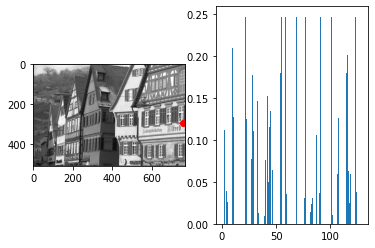

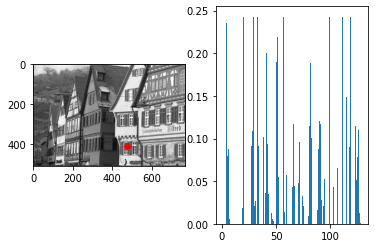

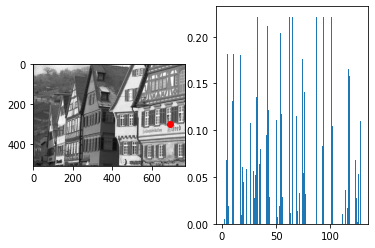

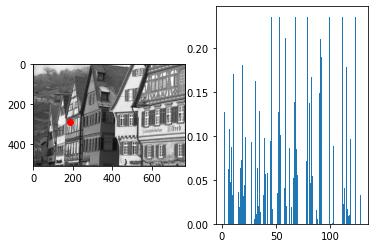

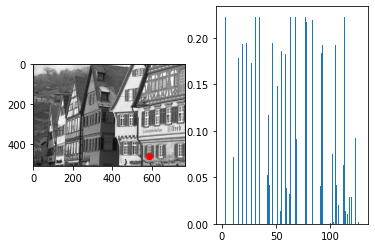

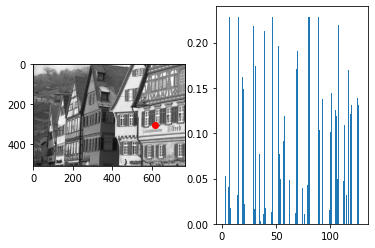

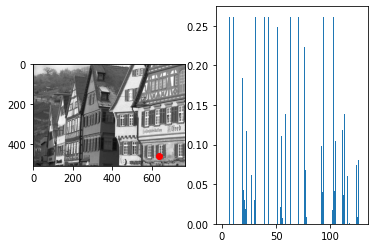

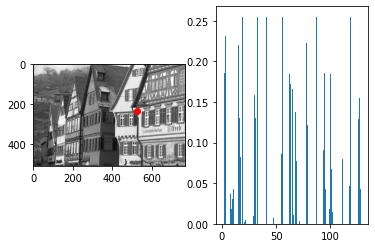

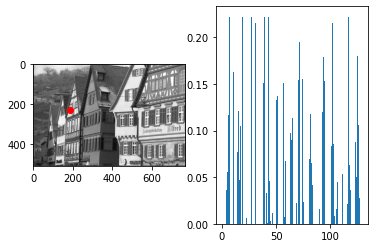

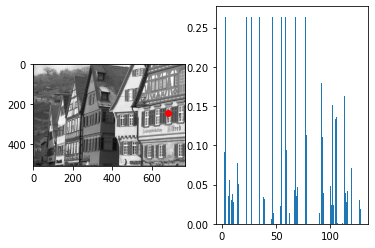

In [ ]:

for i in range(0,10):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(input_image,cmap='gray')
    ax1.autoscale(False)
    ax1.plot(final_points[i][1],final_points[i][0], 'ro')
    ax2.bar(np.arange(1,129),final_descriptor[i,:])
    plt.show()



## PART C - correspondance in 2 images

Finding corresponding points in two images based on SIFT descriptors.
-  Using your program in Part A and Part B to detect feature points and generate their descriptors for two images provided with this assignment.(image named **left** and **right**)
-  Write a program that can find matching points between the two images. For each detected point p in the first image, compute its distance to each detected point in the second image (using Euclidean distance between two SIFT descriptors, not spatial distance) to find two closest points q1 and q2 in the second image. Let us call the distance of p to q1 and q2 by d1 and d2, you will take point q1 as the matching point for p if d1/d2 <r. Otherwise, you assume there is ambiguity between q1 and q2 and skip the feature point p in image 1. You can experiment with different threshold r. Obviously r should be <1. At the end of this process, you should have a set of matching pairs.
-  Create an image that shows the matching results. For example you can create a large image that has the left and right images side by side, and draw lines between matching pairs in these two images. Do the matched points look reasonable? You can use **cv2.line()** to draw line between each matching pair. Display the image after you add lines into the image array using the cv2.line() function.

In [ ]:
################################################ TODO ###############################################
img1 = cv2.imread('left.JPG' ,0).astype('float') # read left image
img_1 = cv2.normalize(img1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

descriptor_1, keypoints_1 = part_B(img_1)

################################################ TODO ###############################################

img2 = cv2.imread('right.JPG' ,0).astype('float') # read right image
img_2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

descriptor_2, keypoints_2 = part_B(img_2)



(300, 400)
<class 'numpy.ndarray'>
Final descriptor 0 (101, 128)
(300, 400)
<class 'numpy.ndarray'>
Final descriptor 0 (101, 128)


Text(0.5, 1.0, 'Keypoints for Right Image')

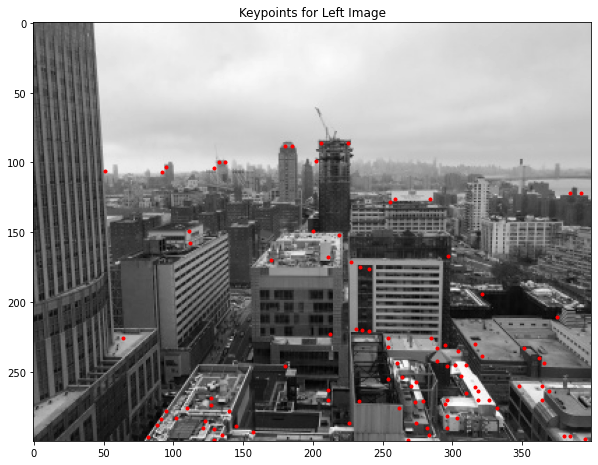

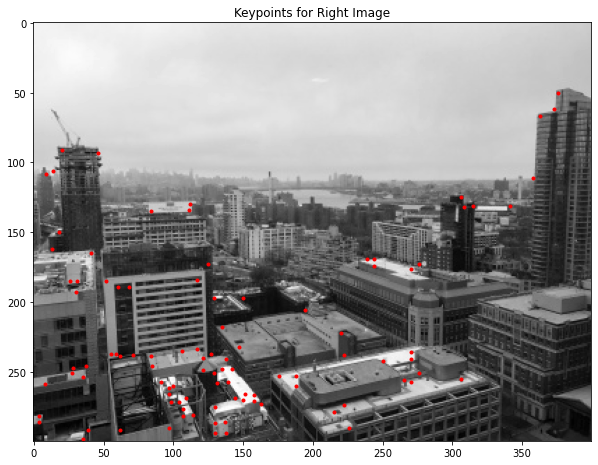

In [ ]:
################################################ TODO ###############################################
# Display detected points in the two images
plt.figure(figsize = (10,10))
plt.imshow(img_1,'gray')
plt.plot(keypoints_1[:,1],keypoints_1[:,0],'ro',ms=3)
plt.title('Keypoints for Left Image')
plt.figure(figsize = (10,10))
plt.imshow(img_2,'gray')
plt.plot(keypoints_2[:,1],keypoints_2[:,0],'ro',ms=3)
plt.title('Keypoints for Right Image')

(300, 800)
Threshold:  0.1
Number of corresponding poitnts found: 0


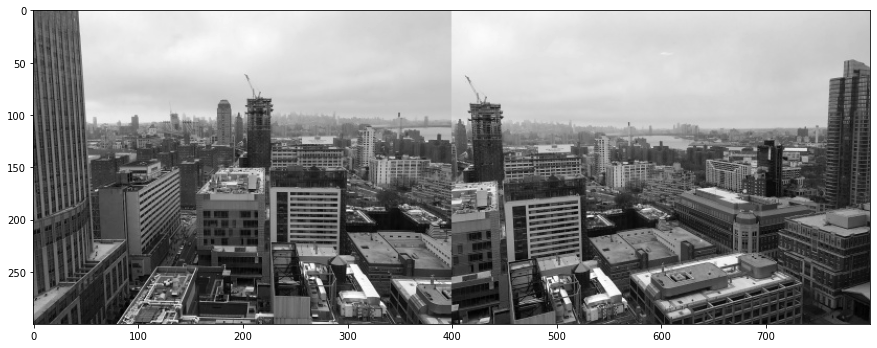

(300, 800)
Threshold:  0.2
Number of corresponding poitnts found: 0


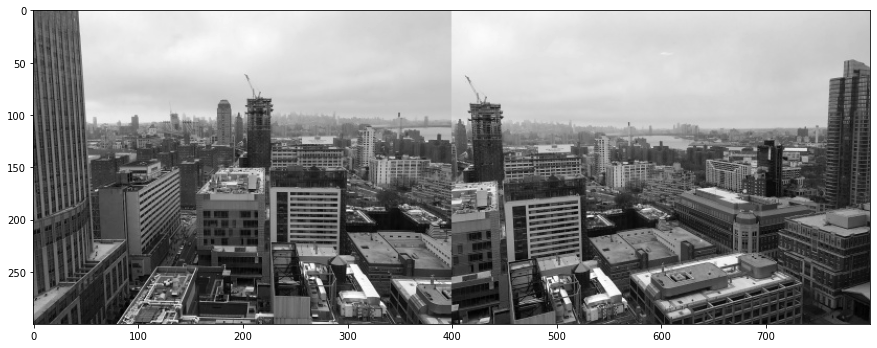

(300, 800)
Threshold:  0.3
Number of corresponding poitnts found: 0


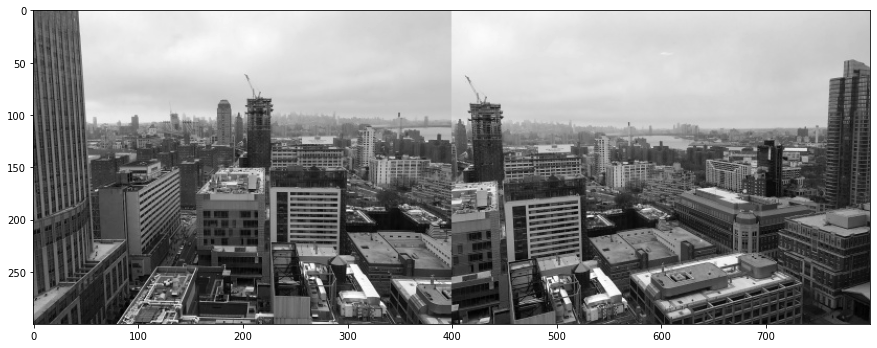

(300, 800)
Threshold:  0.4
Number of corresponding poitnts found: 0


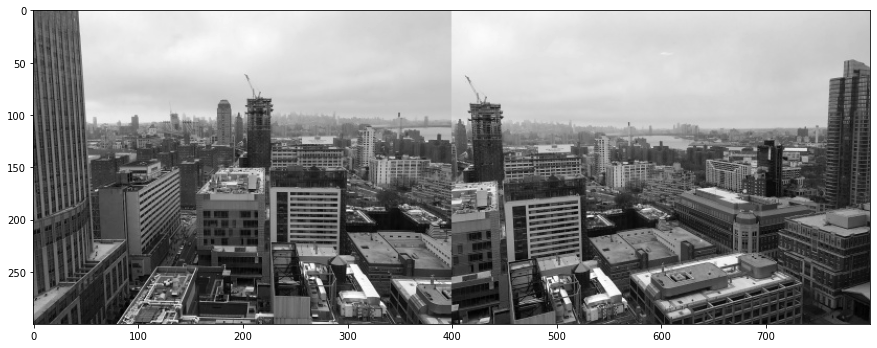

(300, 800)
Threshold:  0.5
Number of corresponding poitnts found: 2


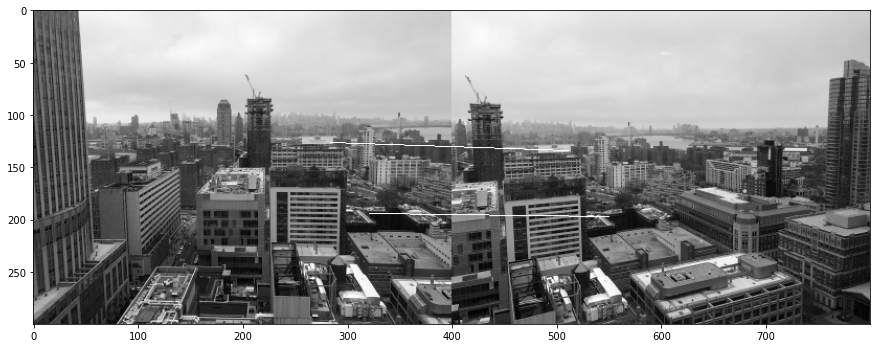

(300, 800)
Threshold:  0.6
Number of corresponding poitnts found: 12


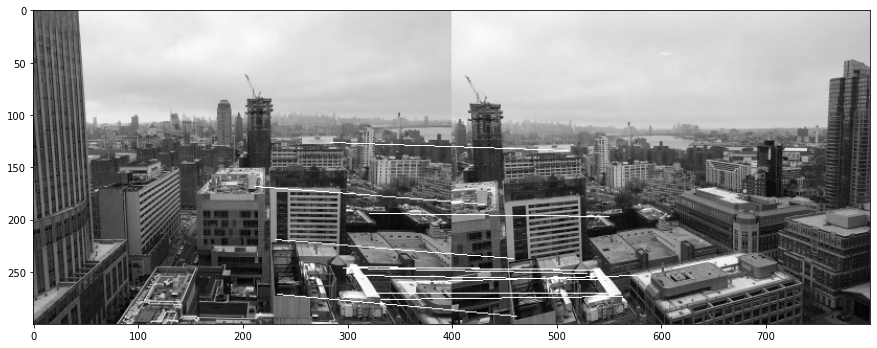

(300, 800)
Threshold:  0.7
Number of corresponding poitnts found: 33


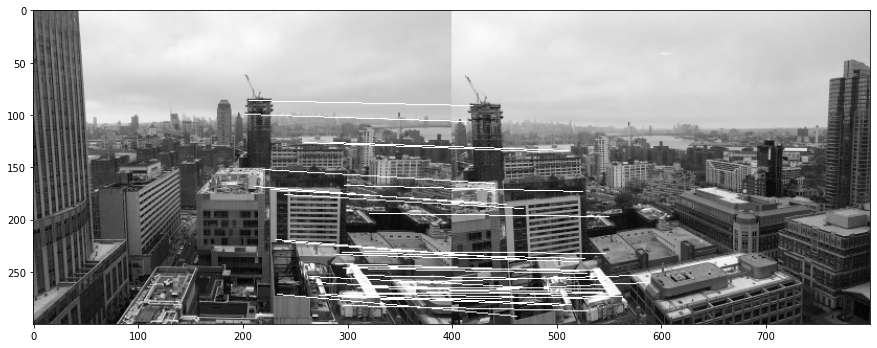

(300, 800)
Threshold:  0.8
Number of corresponding poitnts found: 43


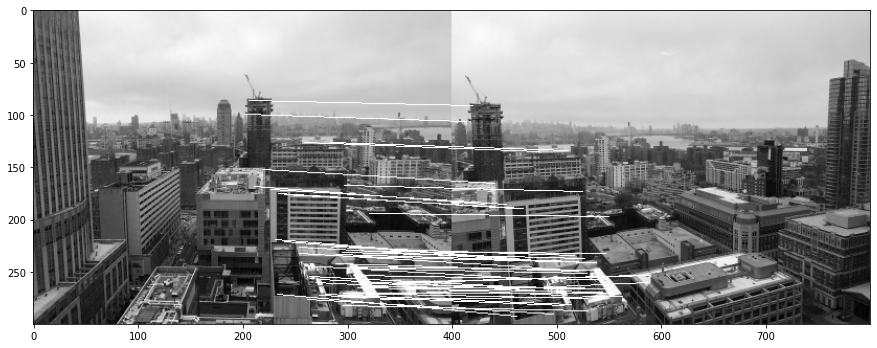

(300, 800)
Threshold:  0.9
Number of corresponding poitnts found: 53


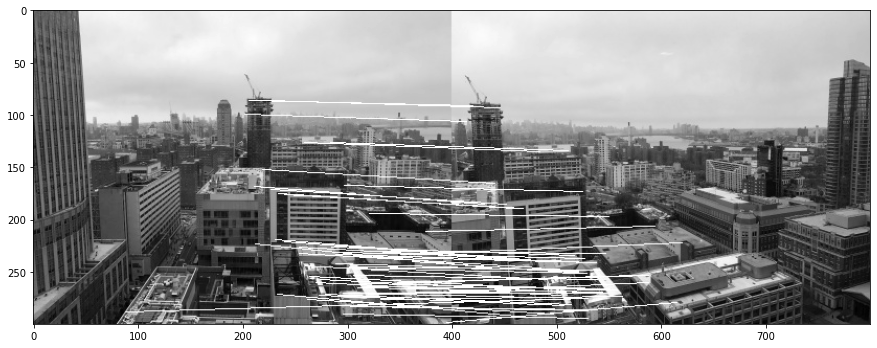

(300, 800)
Threshold:  1.0
Number of corresponding poitnts found: 100


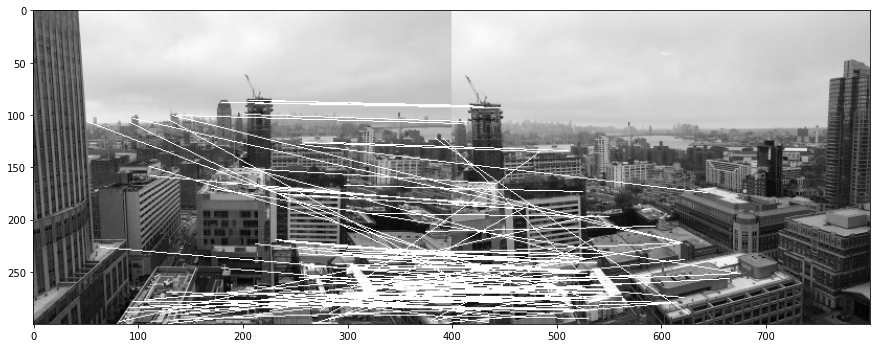

In [ ]:
# write function to find corresponding points in image
def points_matching(kp1, descriptor1, kp2, descriptor2, threshold):
    p1 = np.zeros([1,128])
    q1 = np.zeros((1,2))
    p2 = np.zeros([1,128])
    p = np.zeros((1,2))
    
    dist = list()

    matched_loca = list() # list of all corresponding points pairs. Point pairs can be stored as tuples

    ################################################ TODO ###############################################
    ### Find matching points between img1 and img2 using the algorithm described in the above
    for i in range(kp1.shape[0]):
        dist.clear()
        p1 = descriptor1[i]
        p = kp1[i]
        for m in range(kp2.shape[0]):
          p2 = descriptor2[m]
          d = np.linalg.norm(p1-p2)
          dist.append(d)
        
        di = np.asarray(dist)
        s = np.argsort(di)
        d1 = di[s[0]]
        d2 = di[s[1]]
        if((d1/d2) < threshold):
          q1 = kp2[s[0]]
          q2 = kp2[s[1]]
          point = (p,q1)
          matched_loca.append(point)
    return matched_loca


for r in range(1,11): #Test different thresholds for the matching
    r = r/10
    matched_loca = points_matching(keypoints_1, descriptor_1, keypoints_2, descriptor_2, r)
    final_image = np.concatenate((img_1,img_2),axis=1)
    print(final_image.shape)
    print('Threshold: ', r)
    print('Number of corresponding poitnts found:',len(matched_loca))
    ################################################ TODO ###############################################
    # write code segment to draw lines joining corresponding points
    # Use cv2.line() to draw the line on final_image
    for pt in matched_loca:
        p1 = pt[0]
        p2 = pt[1]
        x,y = p1[0],p1[1]
        x_1,y_1 = p2[0],p2[1]
        x,y,x_1,y_1=int(x),int(y),int(x_1),int(y_1)
        point1 = (y,x)
        point2 = (y_1+400,x_1)
        cv2.line(final_image, point1, point2, (255,255,255), 1)
        
    plt.figure(figsize=(15,15))
    plt.imshow(final_image,cmap='gray')
    plt.show()

## PART D - panorama stiching

Stitch two images into a panorama using SIFT feature detector and descriptor.
In this part, you may use functions from cv2.
- Read in an image pair (left and right)
- Detect SIFT points and extract SIFT features from each image by using the following OpenCV sample code. 



    - sift = cv2.xfeatures2d.SIFT_create()
    - skp = sift.detect(img,None)
    - (skp, features) = sift.compute(img, skp)



[comment]: ![](q_img.png)
 - **Where skp is a list of all the key points found from img and sd is the descriptor for the image. Each element in skp is an OpenCV ‘key points class’ object, and you can check the corresponding coordinate by skp[element_index].pt**
- Detect and mark feature points, calculate their descriptor using cv2 functions.
- Find the corresponding point pairs between left and right images based on their SIFT descriptors. You can reuse your program for Part-C.
- Apply RANSAC method to these matching pairs to find the largest subset of matching pairs that are related by the same homography. You can use the function cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC)
- Create an image that shows the matching results by drawing lines between corresponding points. You can use the drawMatches function below
- Apply the homography to the right image. You can use cv2.warpPerspective() to apply the homography transformation to the image.
- Stitch the transformed right image and the left image together to generate the panorama.


**In your report, show the left and right images, the left and right images with SIFT points indicated, the image that illustrates the matching line between corresponding points, the transformed left image, and finally the stitched image.**

In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 143kB/s 
     |████████████████████████████████| 20.2MB 12.7MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


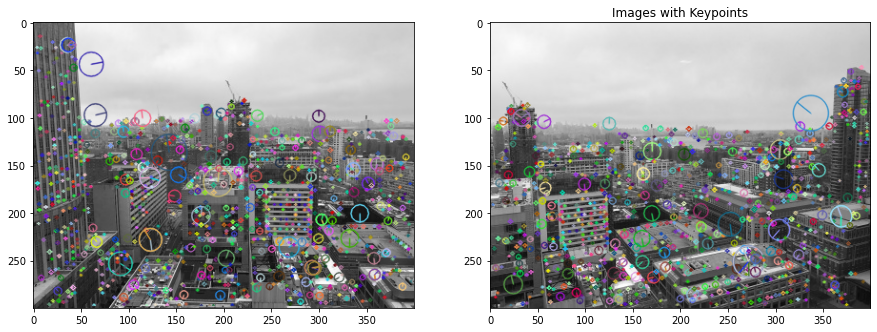

In [ ]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 255, 255), 1)
    # return the visualization
    return vis

################################################ TODO ###############################################
img1 = cv2.imread('left.JPG' ,0) # read left image
img2 = cv2.imread('right.JPG' ,0) # read right iamge

sift = cv2.xfeatures2d.SIFT_create()

################################################ TODO ###############################################
# use sift.detect to detect features in the images
kp1 = sift.detect(img1,None)
kp2 = sift.detect(img2,None)

img1_kps = cv2.drawKeypoints(img1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kps = cv2.drawKeypoints(img2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1_kps)
plt.subplot(122)
plt.imshow(img2_kps)
plt.title('Images with Keypoints')
plt.show()

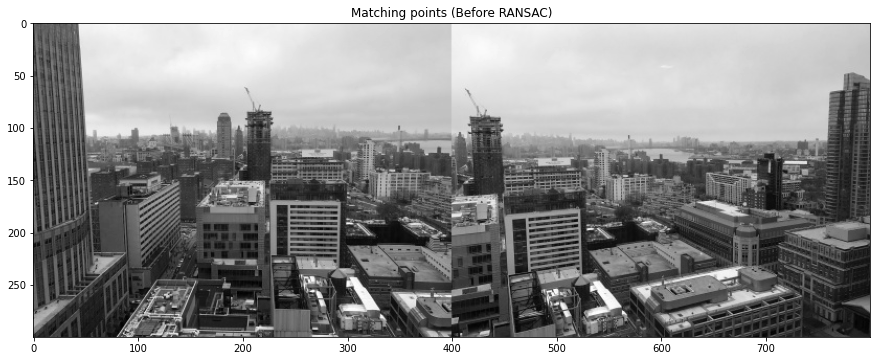

In [ ]:
################################################ TODO ###############################################
# use sift.compute to generate sift descriptors/features
(kp1, features1) = sift.compute(img1,kp1)
(kp2, features2) = sift.compute(img2,kp2)


kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

matcher = cv2.DescriptorMatcher_create("BruteForce")
################################################ TODO ###############################################
# use knnMatch function in matcher to find corresonding features
rawMatches = matcher.knnMatch(features1, features2 ,k=2 )
matches = []

for m in rawMatches:
    # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    ################################################ TODO ###############################################
    if len(m) == 2 and m[0].distance < 0.7*m[1].distance: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
        matches.append((m[0].trainIdx, m[0].queryIdx))

ptsA = np.float32([kp1[i] for (_,i) in matches])
ptsB = np.float32([kp2[i] for (i,_) in matches])

### Similar to what we did in part C
### Create an image img_match that shows the matching results by drawing lines between corresponding points. 
img_match = drawMatches(img1, img2, kp1, kp2, rawMatches, matches)
plt.figure(figsize=(15,15))
plt.imshow(img_match,'gray')
plt.title('Matching points (Before RANSAC)')
plt.show()


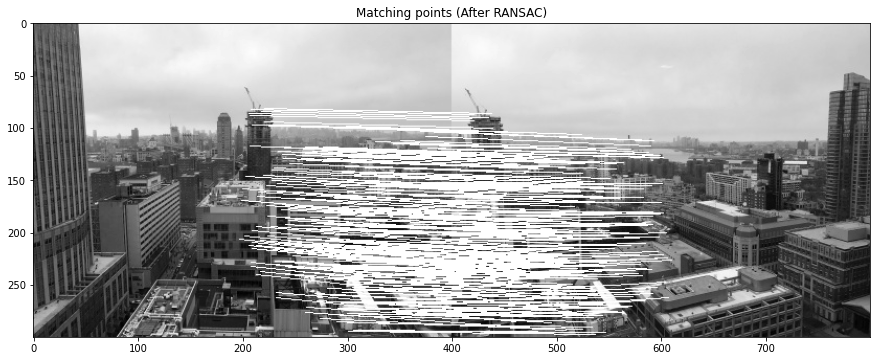

Text(0.5, 1.0, 'Stitched image')

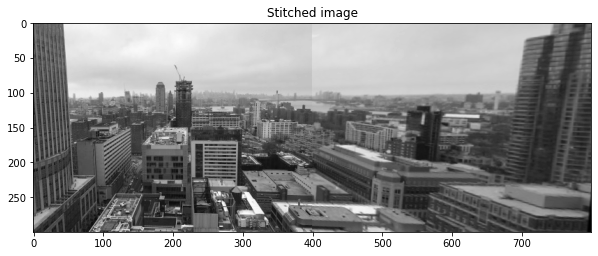

In [ ]:
################################################ TODO ###############################################
# Find homography with RANSAC
(H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC)

img_ransac = drawMatches(img1,img2,kp1,kp2,matches,status)
plt.figure(figsize=(15,15))
plt.imshow(img_ransac,'gray')
plt.title('Matching points (After RANSAC)')
plt.show()

# fill in the arguments to warp the second image to fit the first image.
# For the size of the resulting image, you can set the height to be the same as the original, width to be twice the original.
# First transform the right image, then fill in the left part with the orignal left image
result = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0] , 0:img1.shape[1]] = img1

plt.figure(figsize=(10,20))
plt.imshow(result,'gray')
plt.title('Stitched image')



Text(0.5, 1.0, 'Stitched image: Large size')

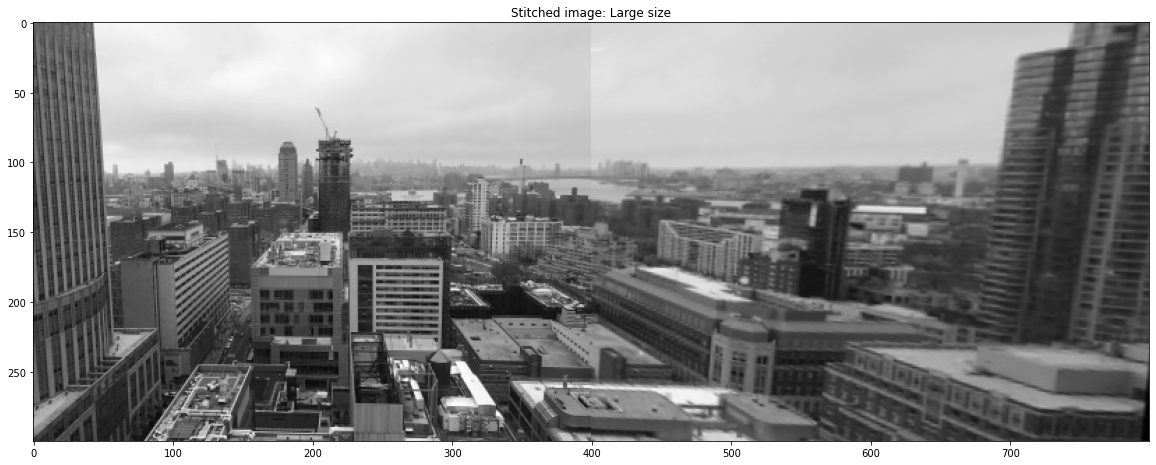

In [ ]:
plt.figure(figsize=(20,40))
plt.imshow(result,'gray')
plt.title('Stitched image: Large size')